## **1. Google Drive**

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# cur_dir = "/content/drive/Othercomputers/My laptop/POLIMI/AN2DL/AN2DL_CH_2/Notebooks"
# %cd $cur_dir


In [6]:
#%pip install torchview


## **2. Import Libraries**

In [7]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
from scipy import ndimage
from PIL import Image

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
import shutil
import gc
from sklearn.preprocessing import LabelEncoder

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

'pkill' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


PyTorch version: 2.5.1+cu121
Device: cuda


## **3. Config**

In [8]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path

# preprocessing output paths
#preprocessing step 1 output path
GOO_REMOVAL_OUT = os.path.join(datasets_path, "preprocessing_results","train_nogoo")

#preprocessing step 2 output path
SHREK_REMOVAL_OUT = os.path.join(datasets_path, "preprocessing_results","train_noshreks")
SHREKS_OUT = os.path.join(SHREK_REMOVAL_OUT, "train_shreks")
TISSUE_OUT = os.path.join(SHREK_REMOVAL_OUT, "train_tissue")


  # Where the resized unmasked images will be saved
PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Goo removal output path: {GOO_REMOVAL_OUT}")
print(f"Shrek removal output path: {SHREK_REMOVAL_OUT}")
print(f"Shreks output path: {SHREKS_OUT}")
print(f"Tissue output path: {TISSUE_OUT}")
print(f"Patches output path: {PATCHES_OUT}")

TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ..\an2dl2526c2
Train data path: ..\an2dl2526c2\train_data
Train labels path: ..\an2dl2526c2\train_labels.csv
Test data path: ..\an2dl2526c2\test_data
Goo removal output path: ..\an2dl2526c2\preprocessing_results\train_nogoo
Shrek removal output path: ..\an2dl2526c2\preprocessing_results\train_noshreks
Shreks output path: ..\an2dl2526c2\preprocessing_results\train_noshreks\train_shreks
Tissue output path: ..\an2dl2526c2\preprocessing_results\train_noshreks\train_tissue
Patches output path: ..\an2dl2526c2\preprocessing_results\train_patches


## **4. Train/Val Split**

In [9]:
def create_metadata_dataframe(patches_dir, labels_csv_path):
    """
    Creates a DataFrame mapping patch filenames to their Bag IDs and Labels.
    """
    # 1. Load the labels CSV
    # Assuming CSV structure: [image_id, label] or similar
    df_labels = pd.read_csv(labels_csv_path)
    
    # Standardize column names for easier merging
    # We assume the first column is the ID and the second is the Label
    id_col = df_labels.columns[0]
    label_col = df_labels.columns[1]
    
    # Ensure IDs in CSV are strings (to match filenames)
    df_labels[id_col] = df_labels[id_col].astype(str)
    
    # If the CSV IDs contain extensions (e.g., 'img_001.png'), remove them
    # because our parsed Bag IDs won't have them.
    df_labels[id_col] = df_labels[id_col].apply(lambda x: os.path.splitext(x)[0])

    # 2. List all patch files
    patch_files = [f for f in os.listdir(patches_dir) if f.endswith('.png')]
    
    # 3. Parse filenames to get Bag IDs
    data = []
    print(f"Found {len(patch_files)} patches. Parsing metadata...")
    
    for filename in patch_files:
        # Expected format from your preprocessing: {base_name}_p{i}.png
        # Example: "img_0015_p12.png" -> Bag ID should be "img_0015"
        
        # Split from the right on '_p' to separate Bag ID from Patch Index
        # "img_0015_p12.png" -> ["img_0015", "12.png"]
        try:
            bag_id = filename.rsplit('_p', 1)[0]
            
            data.append({
                'filename': filename,
                'sample_id': bag_id,
                'path': os.path.join(patches_dir, filename)
            })
        except IndexError:
            print(f"Skipping malformed filename: {filename}")

    # Create temporary patches DataFrame
    df_patches = pd.DataFrame(data)
    
    # 4. Merge patches with labels
    # This assigns the correct Bag Label to every Patch in that Bag
    df = pd.merge(df_patches, df_labels, left_on='sample_id', right_on=id_col, how='inner')
    
    # 5. Clean up and Rename
    # Keep only required columns
    df = df[['filename', label_col, 'sample_id', 'path']]
    
    # Rename label column to standard 'label' if it isn't already
    df = df.rename(columns={label_col: 'label'})
    
    print(f"Successfully created DataFrame with {len(df)} rows.")
    return df

In [10]:
patches_metadata_df = create_metadata_dataframe(PATCHES_OUT, CSV_PATH)

# Verify the result
print("\nFirst 5 rows:")
print(patches_metadata_df.head().drop(columns=['path']))
print("\nPatches per Bag (Distribution):")
print(patches_metadata_df['sample_id'].value_counts().describe())

Found 5704 patches. Parsing metadata...
Successfully created DataFrame with 5704 rows.

First 5 rows:
          filename            label sample_id
0  img_0000_p0.png  Triple negative  img_0000
1  img_0000_p1.png  Triple negative  img_0000
2  img_0000_p2.png  Triple negative  img_0000
3  img_0000_p3.png  Triple negative  img_0000
4  img_0001_p0.png        Luminal A  img_0001

Patches per Bag (Distribution):
count    1261.000000
mean        4.523394
std         2.973235
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        25.000000
Name: count, dtype: float64


In [11]:
# Add Label Encoding
print("\n" + "="*50)
print("Label Encoding")
print("="*50)

label_encoder = LabelEncoder()
patches_metadata_df['label_encoded'] = label_encoder.fit_transform(patches_metadata_df['label'])

print(f"\nOriginal Labels: {label_encoder.classes_}")
print(f"Encoded as: {list(range(len(label_encoder.classes_)))}")
print(f"\nLabel Mapping:")
for orig, enc in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {orig} -> {enc}")


Label Encoding

Original Labels: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Encoded as: [0, 1, 2, 3]

Label Mapping:
  HER2(+) -> 0
  Luminal A -> 1
  Luminal B -> 2
  Triple negative -> 3


In [12]:
# Train/Val Split on Original Images (not patches)
print("\n" + "="*50)
print("Train/Val Split on Original Images")
print("="*50)

# Get unique sample IDs
unique_samples = patches_metadata_df['sample_id'].unique()
print(f"\nTotal unique samples (original images): {len(unique_samples)}")

# Split samples into train (80%) and val (20%)
train_samples, val_samples = train_test_split(
    unique_samples, 
    test_size=0.2, 
    random_state=SEED,
    stratify=patches_metadata_df.drop_duplicates('sample_id').set_index('sample_id').loc[unique_samples, 'label_encoded'].values
)

print(f"Train samples: {len(train_samples)}")
print(f"Val samples: {len(val_samples)}")

# Create train and val DataFrames by filtering patches
df_train = patches_metadata_df[patches_metadata_df['sample_id'].isin(train_samples)].reset_index(drop=True)
df_val = patches_metadata_df[patches_metadata_df['sample_id'].isin(val_samples)].reset_index(drop=True)

print(f"\nTrain patches: {len(df_train)}")
print(f"Val patches: {len(df_val)}")
print(f"\nTrain label distribution:\n{df_train['label'].value_counts()}")
print(f"\nVal label distribution:\n{df_val['label'].value_counts()}")

# Print percentage distribution
print(f"\n" + "="*50)
print("Percentage Distribution")
print("="*50)
print(f"\nTrain label percentage:\n{df_train['label'].value_counts(normalize=True) * 100}")
print(f"\nVal label percentage:\n{df_val['label'].value_counts(normalize=True) * 100}")


Train/Val Split on Original Images

Total unique samples (original images): 1261
Train samples: 1008
Val samples: 253

Train patches: 4537
Val patches: 1167

Train label distribution:
label
Luminal B          1552
Luminal A          1276
HER2(+)            1161
Triple negative     548
Name: count, dtype: int64

Val label distribution:
label
Luminal B          389
HER2(+)            345
Luminal A          287
Triple negative    146
Name: count, dtype: int64

Percentage Distribution

Train label percentage:
label
Luminal B          34.207626
Luminal A          28.124311
HER2(+)            25.589597
Triple negative    12.078466
Name: proportion, dtype: float64

Val label percentage:
label
Luminal B          33.333333
HER2(+)            29.562982
Luminal A          24.592973
Triple negative    12.510711
Name: proportion, dtype: float64


## **5. Transformations & Augmentation**

In [13]:
# ============================================================
# 5. Transformations & Augmentation
# ============================================================

# ImageNet statistics for normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    # Geometric Augmentations (Crucial for rotation-invariant cells)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(degrees=180), # Cells don't have an "up" or "down"

    # Color Augmentation (To handle stain/scanner variations)
    # Brightness/Contrast helps the model ignore background color bias
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),

    # Standard Prep
    transforms.Resize(TARGET_SIZE), # Ensures 224x224
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_transform = transforms.Compose([
    # No augmentation for validation, just resizing and normalization
    transforms.Resize(TARGET_SIZE),
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

## **6. Custom Dataset Class**

In [14]:
class MicroscopyDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing 'path' and 'label_encoded' columns.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 1. Get Path and Label
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label_encoded']

        # 2. Load Image
        # Using PIL as it works natively with torchvision transforms
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image or handle error appropriately
            # For now, we'll return a zero tensor (not ideal but prevents crash)
            return torch.zeros((3, 224, 224)), label

        # 3. Apply Transformations
        if self.transform:
            image = self.transform(image)

        return image, label

## **7. Data Loaders**

In [15]:
# Instantiate Datasets
train_dataset = MicroscopyDataset(df_train, transform=train_transform)
val_dataset = MicroscopyDataset(df_val, transform=val_transform)

# Batch Size: 32 or 64 is standard for ResNet18/50 on 1MP images
BATCH_SIZE = 64

# Instantiate Loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # Shuffle patches to break batch correlations
    num_workers=0,         # Adjust based on your CPU
    pin_memory=True        # Faster data transfer to CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # No need to shuffle validation
    num_workers=0,
    pin_memory=True
)

print(f"Train Loader: {len(train_loader)} batches")
print(f"Val Loader: {len(val_loader)} batches")

Train Loader: 71 batches
Val Loader: 19 batches



Visualizing Training Batch (Augmented):


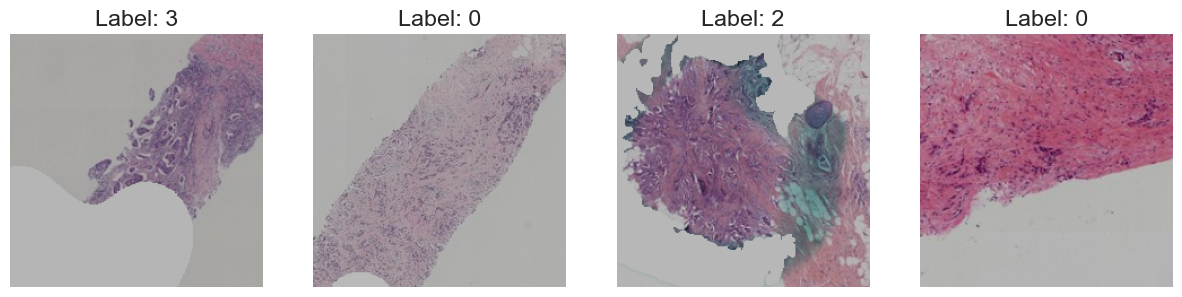

In [16]:
def show_batch(loader, count=4):
    images, labels = next(iter(loader))
    plt.figure(figsize=(15, 5))
    
    # Denormalize for visualization
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)

    for i in range(count):
        ax = plt.subplot(1, count, i + 1)

        img = images[i]
        img = img * std + mean  # Un-normalize
        
        img = torch.clamp(img, 0, 1)  # Clip to valid range
        
        plt.imshow(img.permute(1, 2, 0)) # CHW -> HWC
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.show()

print("\nVisualizing Training Batch (Augmented):")
show_batch(train_loader)

## **8. Hyperparameters**

In [17]:
DROPOUT_RATE = 0.3
HIDDEN_SIZE = 512

NUM_EPOCHS = 10  # Increased since we have early stopping
PATIENCE = 5     # Stop if val_loss doesn't improve for 5 epochs

## **9. Model Definition (Transfer Learning - MobileNetV3)**

In [18]:
class EfficientNetB0TransferLearning(nn.Module):
    """EfficientNet-B0 with ImageNet pretrained weights."""

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True, hidden_size=512):
        super().__init__()

        # Load weights pretrained on ImageNet
        self.backbone = torchvision.models.efficientnet_b0(
            weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
        )

        # Freeze the backbone layers (features)
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False

        # Replace classifier (Always trainable)
        in_features = self.backbone.classifier[-1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(in_features, hidden_size),
            nn.ReLU(),

            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [19]:
# Initialize the model
# Ensure device is defined (usually from previous cells, but safe to redefine if standalone)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming label_encoder is defined in your notebook scope
num_classes = len(label_encoder.classes_) 
model = EfficientNetB0TransferLearning(num_classes, DROPOUT_RATE, freeze_backbone=True, hidden_size=HIDDEN_SIZE).to(device)
model = model.to(device)

print(f"Model initialized (EfficientNetB0) with {num_classes} output classes.")
summary(model, input_size=(3, TARGET_SIZE[0], TARGET_SIZE[1]))

Model initialized (EfficientNetB0) with 4 output classes.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 11

## **10. Loss and Optimizer**

In [20]:
# Use Label Smoothing to handle "benign" patches labeled as cancer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer
optimizer = torch.optim.RAdam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-3,
    # You can also include other Adam parameters like betas, eps, weight_decay
    # betas=(0.9, 0.999), 
    # eps=1e-8, 
    # weight_decay=0
)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True
)

## **11. Training & Validation Loop (F1 Score)**

In [21]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    # Lists to store all predictions and labels for F1 calculation
    all_preds = []
    all_labels = []
    
    loop = tqdm(loader, leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics accumulation
        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        
        # Move to CPU and convert to numpy for sklearn metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        loop.set_description(f"Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(loader.dataset)
    # Calculate F1 Score (Macro for imbalanced data)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return epoch_loss, epoch_f1

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return epoch_loss, epoch_f1

## **12. Main Execution Block (Early Stopping)**

In [39]:
best_val_f1 = 0.0
best_val_loss = float('inf')
patience_counter = 0

history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

print(f"Starting Training with MobileNetV3 (Patience: {PATIENCE})...")

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_f1 = validate(model, val_loader, criterion, device)
    
    # Update Scheduler (based on Loss)
    scheduler.step(val_loss)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} F1: {val_f1:.4f}")
    
    # --- Checkpointing (Save Best Model based on F1) ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'models/best_model_efficentnetb0_tl.pt')
        print(f"   >>> Found best model (F1: {best_val_f1:.4f}). Saved.")

    # --- Early Stopping (Monitor Val Loss) ---
    # We monitor Loss for stopping because F1 can fluctuate even if model is converging
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter
    else:
        patience_counter += 1
        print(f"   >>> EarlyStopping counter: {patience_counter}/{PATIENCE}")
        
    if patience_counter >= PATIENCE:
        print("   >>> Early Stopping Triggered! Training stopped.")
        break

Starting Training with MobileNetV3 (Patience: 5)...


Epoch 1/10 | Train Loss: 1.3536 F1: 0.2353 | Val Loss: 1.3438 F1: 0.1576
   >>> Found best model (F1: 0.1576). Saved.


Epoch 2/10 | Train Loss: 1.3286 F1: 0.2416 | Val Loss: 1.3452 F1: 0.2229
   >>> Found best model (F1: 0.2229). Saved.
   >>> EarlyStopping counter: 1/5


Epoch 3/10 | Train Loss: 1.3103 F1: 0.2857 | Val Loss: 1.3541 F1: 0.2206
   >>> EarlyStopping counter: 2/5


Epoch 4/10 | Train Loss: 1.2940 F1: 0.3171 | Val Loss: 1.3474 F1: 0.2518
   >>> Found best model (F1: 0.2518). Saved.
   >>> EarlyStopping counter: 3/5


Epoch 5/10 | Train Loss: 1.2818 F1: 0.3484 | Val Loss: 1.3459 F1: 0.2561
   >>> Found best model (F1: 0.2561). Saved.
   >>> EarlyStopping counter: 4/5


Epoch 6/10 | Train Loss: 1.2567 F1: 0.3831 | Val Loss: 1.3487 F1: 0.2606
   >>> Found best model (F1: 0.2606). Saved.
   >>> EarlyStopping counter: 5/5
   >>> Early Stopping Triggered! Training stopped.


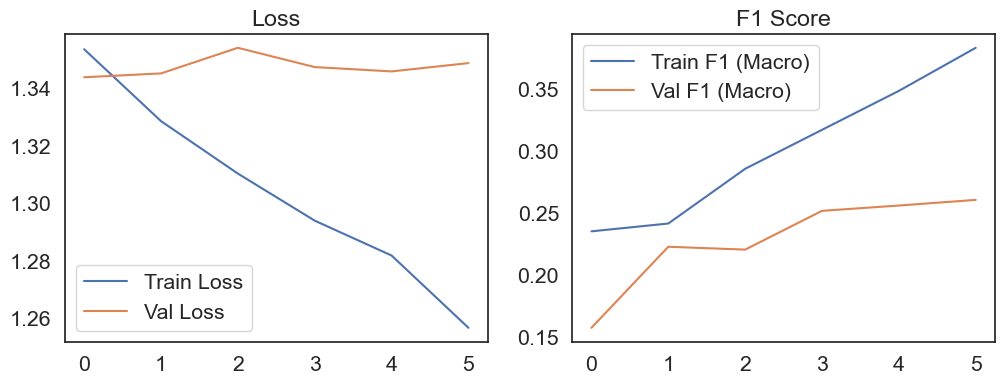

In [40]:
# Plotting results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='Train F1 (Macro)')
plt.plot(history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

In [41]:
def get_image_predictions(model, loader, device):
    """
    Aggregates patch-level predictions to image-level.
    Strategy: Average the Softmax probabilities of all patches in a bag,
    then take the argmax. This handles 'noisy/benign' patches well.
    """
    model.eval()
    
    # Access the dataframe and transform stored in the dataset
    dataset = loader.dataset
    df = dataset.df
    transform = dataset.transform
    
    y_true = []
    y_pred = []
    
    # Get unique sample IDs (original images)
    sample_ids = df['sample_id'].unique()
    
    print(f"\nAggregating predictions for {len(sample_ids)} unique images...")
    
    for sample_id in tqdm(sample_ids, leave=False):
        # Get all patches belonging to this image
        sample_patches = df[df['sample_id'] == sample_id]
        
        # Ground Truth (all patches share the image label)
        true_label = sample_patches.iloc[0]['label_encoded']
        y_true.append(true_label)
        
        # Load and process all patches for this image
        patches = []
        for img_path in sample_patches['path']:
            try:
                # Load image (ensure RGB)
                img = Image.open(img_path).convert('RGB')
                if transform:
                    img = transform(img)
                patches.append(img)
            except Exception as e:
                continue
        
        if not patches:
            y_pred.append(true_label) # Fallback (should not happen)
            continue
            
        # Stack patches into a single batch: [Num_Patches, 3, 224, 224]
        batch = torch.stack(patches).to(device)
        
        with torch.no_grad():
            logits = model(batch)
            probs = torch.softmax(logits, dim=1)
            
            # --- Aggregation: Mean Probability ---
            # Averaging probabilities reduces the impact of outliers (benign patches)
            avg_probs = torch.mean(probs, dim=0)
            pred_label = torch.argmax(avg_probs).item()
            
        y_pred.append(pred_label)
        
    return y_true, y_pred


Generating Confusion Matrix on Original Images...

Aggregating predictions for 253 unique images...


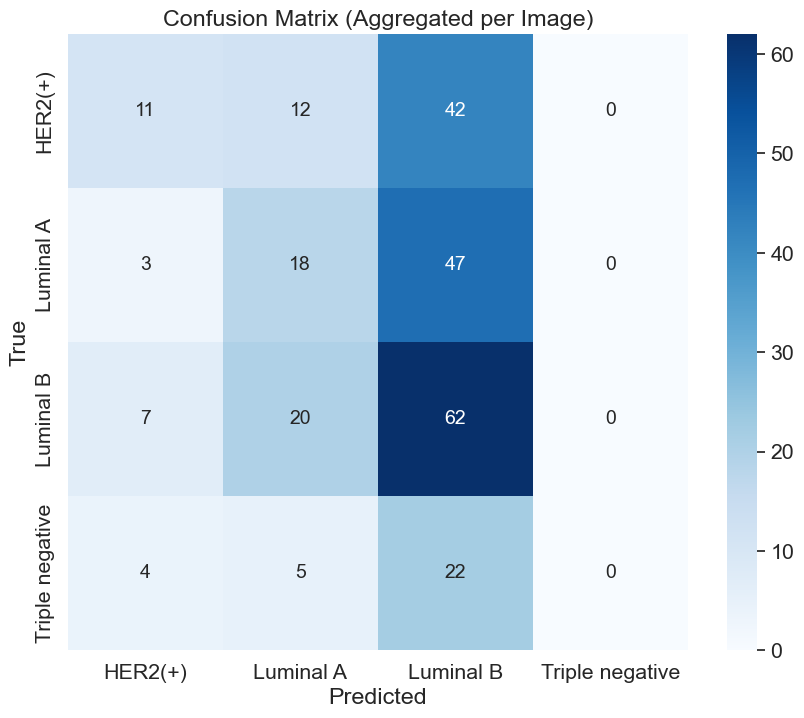

In [42]:

# 3. Calculate and Plot Confusion Matrix
print("Generating Confusion Matrix on Original Images...")
y_true_img, y_pred_img = get_image_predictions(model, val_loader, device)

# Compute Matrix
cm = confusion_matrix(y_true_img, y_pred_img)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated per Image)')
plt.show()

In [43]:
def plot_sample_with_predictions(model, loader, device, label_encoder, sample_id=None):
    """Plot all patches of a single sample and the aggregated image prediction."""
    import math
    model.eval()
    dataset = loader.dataset
    df = dataset.df

    # Pick a sample_id
    if sample_id is None:
        sample_id = np.random.choice(df['sample_id'].unique())
    sample_patches = df[df['sample_id'] == sample_id].reset_index(drop=True)

    # Load and transform all patches
    images_tensors = []
    display_imgs = []
    for _, row in sample_patches.iterrows():
        img = Image.open(row['path']).convert('RGB')
        if dataset.transform:
            tensor_img = dataset.transform(img)
        else:
            tensor_img = transforms.ToTensor()(img)
        images_tensors.append(tensor_img)
        # denormalize for display
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        display_imgs.append(torch.clamp(tensor_img * std + mean, 0, 1))

    batch = torch.stack(images_tensors).to(device)
    with torch.no_grad():
        logits = model(batch)
        probs = torch.softmax(logits, dim=1).cpu()

    patch_preds = probs.argmax(dim=1).numpy()
    patch_confs = probs.max(dim=1).values.numpy()
    image_probs = probs.mean(dim=0).numpy()
    image_pred = image_probs.argmax()
    image_pred_label = label_encoder.inverse_transform([image_pred])[0]
    image_conf = image_probs[image_pred]
    true_label = label_encoder.inverse_transform([sample_patches.iloc[0]['label_encoded']])[0]

    cols = min(6, len(sample_patches))
    rows = math.ceil(len(sample_patches) / cols)
    fig = plt.figure(figsize=(3*cols + 4, 3*rows))
    gs = fig.add_gridspec(rows, cols + 1, width_ratios=[1]*cols + [1.3])

    # Patch grid
    for idx, (img_disp, pred, conf) in enumerate(zip(display_imgs, patch_preds, patch_confs)):
        ax = fig.add_subplot(gs[idx // cols, idx % cols])
        ax.imshow(img_disp.permute(1,2,0))
        lbl = label_encoder.inverse_transform([pred])[0]
        ax.set_title(f"{lbl}\n{conf:.2%}", fontsize=9)
        ax.axis('off')

    # Aggregated distribution
    ax_bar = fig.add_subplot(gs[:, -1])
    class_names = label_encoder.classes_
    colors = ['green' if i == image_pred else 'steelblue' for i in range(len(class_names))]
    ax_bar.barh(class_names, image_probs, color=colors)
    ax_bar.set_xlabel('Probability')
    ax_bar.set_xlim([0,1])
    ax_bar.set_title(f"Sample: {sample_id}\nTrue: {true_label} | Pred: {image_pred_label} ({image_conf:.2%})")
    for i, prob in enumerate(image_probs):
        ax_bar.text(prob + 0.02, i, f"{prob:.3f}", va='center')
    plt.tight_layout()
    plt.show()


Plotting random validation sample with prediction distribution:


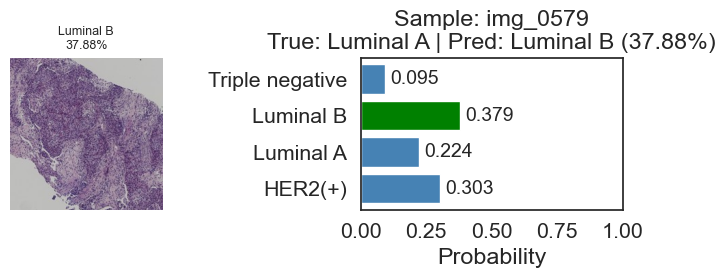

In [44]:
# Visualize a random validation sample
print("Plotting random validation sample with prediction distribution:")
plot_sample_with_predictions(model, val_loader, device, label_encoder)

## **13. Fine Tune**

In [ ]:
# 1. Initialize the NEW model instance
#    (Make sure to use the same class definition you used for training)
ft_model = EfficientNetB0TransferLearning(
    num_classes, 
    dropout_rate=DROPOUT_RATE, 
    freeze_backbone=True,
    hidden_size=HIDDEN_SIZE 
).to(device)

# 2. Load the best weights from the first phase
ft_model.load_state_dict(torch.load("models/best_model_efficentnetb0_tl.pt"), strict=True)

# 3. Unfreeze parameters
#    First, ensure everything is frozen
for param in ft_model.parameters():
    param.requires_grad = False

#    Unfreeze the Classifier (Head)
for param in ft_model.backbone.classifier.parameters():
    param.requires_grad = True

#    Unfreeze the last 2 blocks of the Backbone (Features)
#    EfficientNet B0 features are in 'ft_model.backbone.features'
for block in ft_model.backbone.features[-2:]:
    for param in block.parameters():
        param.requires_grad = True

# 4. CREATE A NEW OPTIMIZER 
ft_optimizer = torch.optim.RAdam(
    [p for p in ft_model.parameters() if p.requires_grad],
    lr=1e-4 
)

# 5. New Scheduler for the new optimizer
ft_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    ft_optimizer, mode='min', factor=0.1, patience=3, verbose=True
)

print("Starting Fine-Tuning (with corrected optimizer)...")

# Reset history
ft_history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
best_ft_f1 = 0.0

# Training Loop using ft_model and ft_optimizer
for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_f1 = train_one_epoch(ft_model, train_loader, criterion, ft_optimizer, device)
    
    # Validate
    val_loss, val_f1 = validate(ft_model, val_loader, criterion, device)
    
    # Update Scheduler
    ft_scheduler.step(val_loss)
    
    ft_history['train_loss'].append(train_loss)
    ft_history['train_f1'].append(train_f1)
    ft_history['val_loss'].append(val_loss)
    ft_history['val_f1'].append(val_f1)
    
    print(f"FT Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_ft_f1:
        best_ft_f1 = val_f1
        torch.save(ft_model.state_dict(), 'models/efficientnetb0_finetuned.pt')
        print(f"   >>> Saved Best Fine-Tuned Model (F1: {best_ft_f1:.4f})")

Starting Fine-Tuning (with corrected optimizer)...


FT Epoch 1/10 | Loss: 1.2516 | F1: 0.3686 | Val F1: 0.2681
   >>> Saved Best Fine-Tuned Model (F1: 0.2681)


FT Epoch 2/10 | Loss: 1.2502 | F1: 0.3854 | Val F1: 0.2763
   >>> Saved Best Fine-Tuned Model (F1: 0.2763)


FT Epoch 3/10 | Loss: 1.2423 | F1: 0.3821 | Val F1: 0.2764
   >>> Saved Best Fine-Tuned Model (F1: 0.2764)


FT Epoch 4/10 | Loss: 1.2325 | F1: 0.4153 | Val F1: 0.2966
   >>> Saved Best Fine-Tuned Model (F1: 0.2966)


FT Epoch 5/10 | Loss: 1.2274 | F1: 0.4157 | Val F1: 0.2848


FT Epoch 6/10 | Loss: 1.2152 | F1: 0.4267 | Val F1: 0.3050
   >>> Saved Best Fine-Tuned Model (F1: 0.3050)


FT Epoch 7/10 | Loss: 1.2045 | F1: 0.4555 | Val F1: 0.3050
   >>> Saved Best Fine-Tuned Model (F1: 0.3050)


FT Epoch 8/10 | Loss: 1.2042 | F1: 0.4513 | Val F1: 0.3108
   >>> Saved Best Fine-Tuned Model (F1: 0.3108)


FT Epoch 9/10 | Loss: 1.2065 | F1: 0.4510 | Val F1: 0.3051


FT Epoch 10/10 | Loss: 1.2027 | F1: 0.4515 | Val F1: 0.3036


Generating Confusion Matrix on Original Images...

Aggregating predictions for 253 unique images...


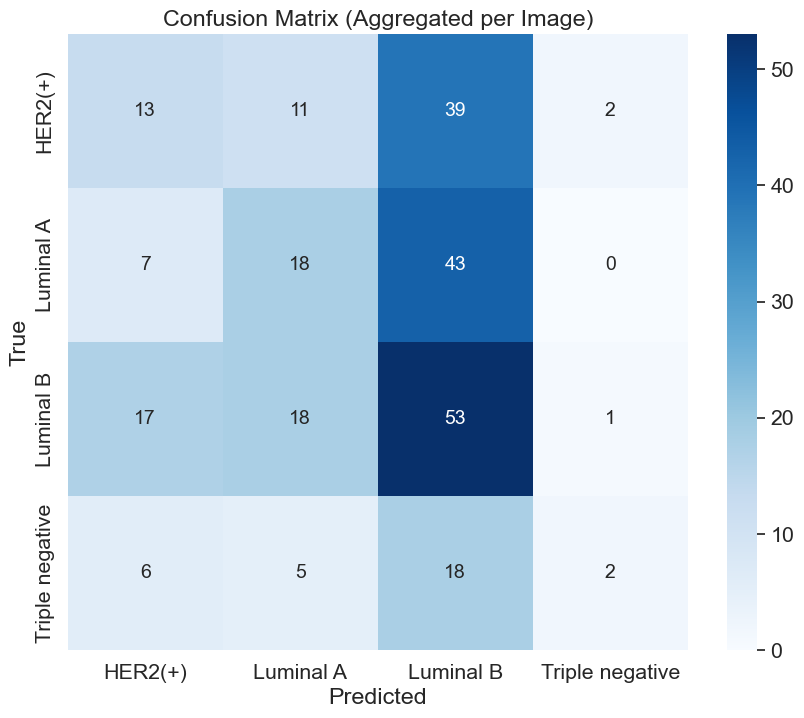

In [46]:

# 3. Calculate and Plot Confusion Matrix
print("Generating Confusion Matrix on Original Images...")
y_true_img_ft, y_pred_img_ft = get_image_predictions(ft_model, val_loader, device)

# Compute Matrix
cm = confusion_matrix(y_true_img_ft, y_pred_img_ft)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated per Image)')
plt.show()

Plotting random validation sample with prediction distribution:


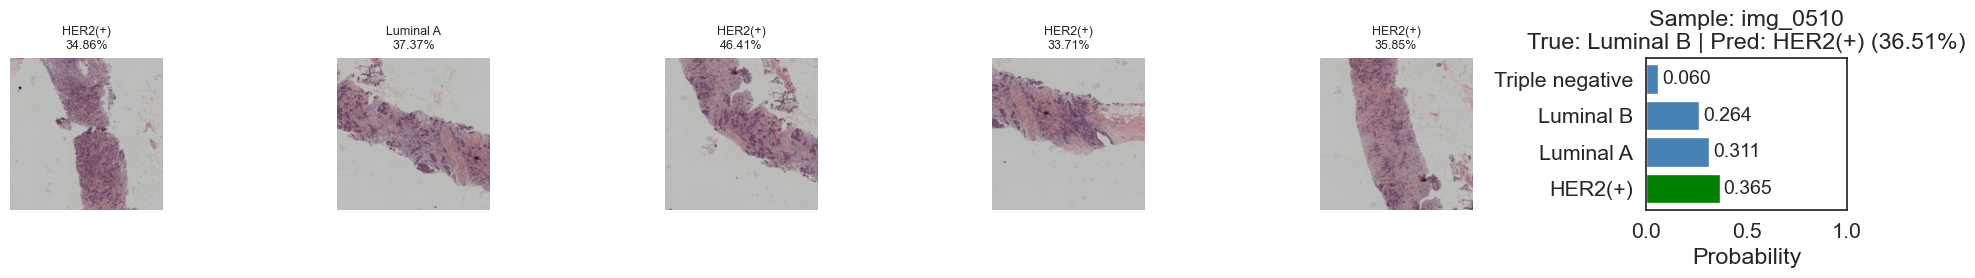

In [48]:
# Visualize a random validation sample
print("Plotting random validation sample with prediction distribution:")
plot_sample_with_predictions(ft_model, val_loader, device, label_encoder)

## **14. Submission Creation**

In [23]:
sub_model = EfficientNetB0TransferLearning(
    num_classes, 
    dropout_rate=DROPOUT_RATE, 
    freeze_backbone=True,
    hidden_size=HIDDEN_SIZE 
).to(device)

# 2. Load the best weights from the first phase
sub_model.load_state_dict(torch.load('models/best_model_finetuned.pt'), strict=True)

<All keys matched successfully>

In [26]:
import os
import pandas as pd
from PIL import Image
import torch.nn.functional as F
import numpy as np

def generate_submission(model, submission_folder, method='max_confidence', output_csv="submission.csv"):
    """
    Generates a submission file by predicting on patches and aggregating results.
    
    Args:
        model: Trained PyTorch model.
        submission_folder: Path to folder containing test patches.
        method: 'majority_voting' or 'max_confidence'.
        output_csv: Filename for the output CSV.
    """
    model.eval()
    
    # 1. Get list of test patches
    patch_files = sorted([f for f in os.listdir(submission_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"Found {len(patch_files)} patches in {submission_folder}")
    print(f"Aggregation Method: {method}")

    # Store predictions per image
    # Structure: { 'img_0001': {'votes': [], 'probs': []}, ... }
    image_predictions = {}

    print("Running inference...")
    with torch.no_grad():
        for filename in tqdm(patch_files):
            filepath = os.path.join(submission_folder, filename)
            
            try:
                # Extract Sample ID (e.g., "img_0015_p12.png" -> "img_0015")
                # Adjust split logic if your naming convention is different
                sample_id = filename.rsplit('_p', 1)[0] 
                
                # Initialize dictionary for this sample if new
                if sample_id not in image_predictions:
                    image_predictions[sample_id] = {'probs': []}

                # Load and Transform
                image = Image.open(filepath).convert('RGB')
                input_tensor = val_transform(image).unsqueeze(0).to(device)
                
                # Predict
                outputs = model(input_tensor)
                probs = torch.softmax(outputs, dim=1)
                
                # Store probabilities for this patch
                image_predictions[sample_id]['probs'].append(probs.cpu().numpy()[0])
                
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # 3. Aggregate Results
    final_results = []
    
    print(f"Aggregating results for {len(image_predictions)} unique samples...")
    
    for sample_id, data in image_predictions.items():
        all_probs = np.array(data['probs']) # Shape: [Num_Patches, Num_Classes]
        
        # Ensure sample_index has .png extension as requested
        sample_index_name = f"{sample_id}.png"

        if len(all_probs) == 0:
            final_results.append({'sample_index': sample_index_name, 'label': "Luminal A"}) # Default fallback
            continue

        if method == 'majority_voting':
            # Get class prediction for each patch
            patch_preds = np.argmax(all_probs, axis=1)
            # Find most frequent class
            counts = np.bincount(patch_preds)
            final_class_idx = np.argmax(counts)
            
        elif method == 'max_confidence':
            # Option A: Average probabilities (Soft Voting) - usually best/safest
            avg_probs = np.mean(all_probs, axis=0)
            final_class_idx = np.argmax(avg_probs)
            
            # Option B: Strict Max Confidence (Uncomment if you prefer this)
            # max_probs = np.max(all_probs, axis=0)
            # final_class_idx = np.argmax(max_probs)

        # Decode Label
        pred_label = label_encoder.inverse_transform([final_class_idx])[0]
        final_results.append({'sample_index': sample_index_name, 'label': pred_label})

    # 4. Create Pandas DataFrame and Save
    df_submission = pd.DataFrame(final_results)
    
    # Ensure correct column order
    df_submission = df_submission[['sample_index', 'label']]
    
    # Sort by sample_index for neatness
    df_submission.sort_values('sample_index', inplace=True)
    
    # Save to CSV
    df_submission.to_csv(output_csv, index=False)
    
    print(f"Submission saved to {output_csv}")
    print(df_submission.head())
    
    return df_submission



In [27]:
# Example Usage:
# Replace 'path/to/SUBMISSION_PATCHES' with the actual path
# If your folder is just named SUBMISSION_PATCHES in current dir:
SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","submission_patches")
OUTPUT_NAME = "submission.csv"


# ==========================================
# Execution
# ==========================================


# Check if folder exists
if os.path.exists(SUBMISSION_PATCHES_OUT):
    # Method 1: Max Confidence / Average Probability (Recommended)
    df_sub_max_conf = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='max_confidence', output_csv=OUTPUT_NAME)
    
    # Method 2: Majority Voting (Optional, uncomment to run)
    # df_sub_majority_voting = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='majority_voting', output_csv="submission_voting.csv")
else:
    print(f"Directory '{SUBMISSION_PATCHES_OUT}' not found. Please create it or set the correct path.")

Found 4216 patches in ..\an2dl2526c2\preprocessing_results\submission_patches
Aggregation Method: max_confidence
Running inference...


100%|██████████| 4216/4216 [01:46<00:00, 39.67it/s]


Aggregating results for 954 unique samples...
Submission saved to submission.csv
   sample_index            label
0  img_0000.png        Luminal B
1  img_0001.png  Triple negative
2  img_0002.png          HER2(+)
3  img_0003.png        Luminal B
4  img_0004.png        Luminal B
